Begun 1/25/2025

Analyzing results from running 264 test maps. This data set corrects a small issue with the filtering transfer function in the number of modes per bin for the covariance, corrects an issue with how I was normalizing the ivar that caused it to often be normalized to a point in the taper, and implements separate masks for the filtering step and the ivar weighting step (discarding the first taper before making the second one). I also added the ability to catch maps that only have tapered points remaining in the second mask - I consider these to be cut by the mask and tapering.

Results are in angle_calc_1737661765

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import pandas as pd
import nawrapper as nw
import yaml
import time
import healpy as hp
from scipy import optimize as op
import os

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1737661765/angle_calc_1737661765_spectra.npy',allow_pickle=True).item()

In [3]:
maps = np.array(list(spectra_dict.keys()))
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

264
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'meas_angle', 'meas_errbar', 'initial_timestamp', 'median_timestamp', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut'])


In [4]:
ivar_sums = np.zeros(n_maps)
residual_sums = np.zeros(n_maps)
all_errbars = np.zeros(n_maps)
for i in range(n_maps):
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
    residual_sums[i] = np.abs(spectra_dict[maps[i]]['residual_sum'])
    all_errbars[i] = np.abs(spectra_dict[maps[i]]['meas_errbar'])
    
print(np.where(residual_sums==9999)[0])   # Maps cut by galaxy mask
print(np.where(all_errbars<0.5)[0])       # Maps where curve_fit failed

[ 43  44  45 109 124 125 126 139 168 229 230 240 241 242 248]
[ 95 246]


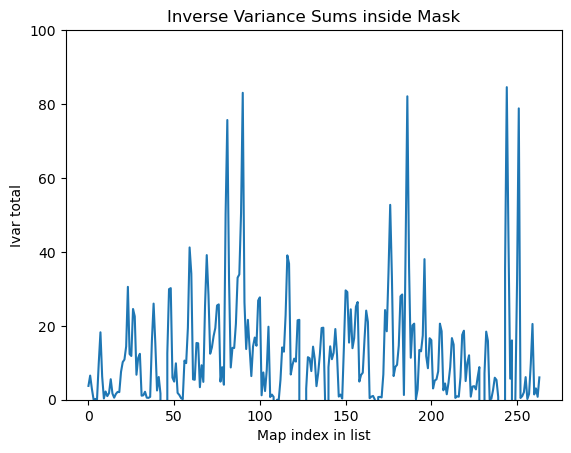

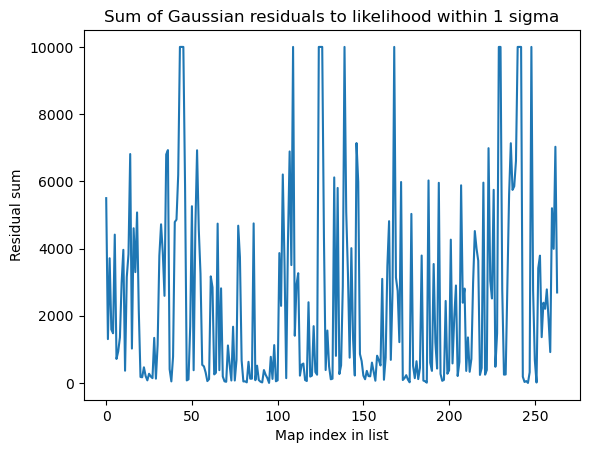

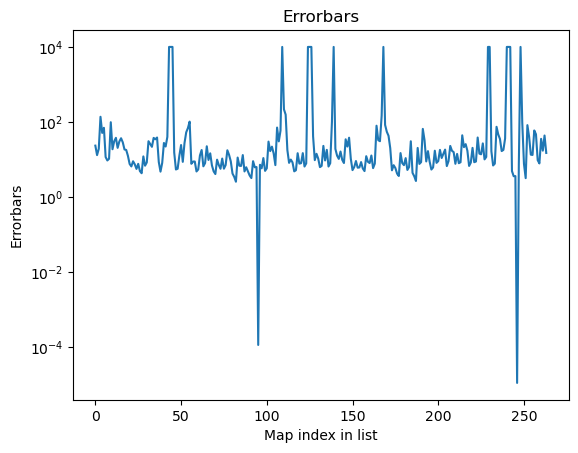

In [5]:
plt.plot(ivar_sums)
plt.ylim(0,100)
plt.title("Inverse Variance Sums inside Mask")
plt.ylabel("Ivar total")
plt.xlabel("Map index in list")
plt.show()
plt.close()
plt.plot(residual_sums)
plt.title("Sum of Gaussian residuals to likelihood within 1 sigma")
plt.ylabel("Residual sum")
plt.xlabel("Map index in list")
plt.show()
plt.close()
plt.semilogy(all_errbars)
plt.title("Errorbars")
plt.ylabel("Errorbars")
plt.xlabel("Map index in list")
plt.show()
plt.close()

In [12]:
maps[246]

'depth1_1617308981_pa4_f150_map.fits'

In [30]:
# List of indices from looking at likelihoods by eye
very_good = [20,21,22,23,24,25,26,27,29,37,38,39,47,48,51,56,57,58,59,60,63,64,66,68,69,70,73,75,76,80,81,82,
             84,85,87,88,89,90,91,92,93,94,97,99,100,105,113,116,117,119,120,122,123,131,132,136,137,145,150,151,
             152,153,154,155,156,157,162,173,174,175,176,177,180,182,183,185,186,187,190,195,196,197,199,200,205,
             218,221,222,232,233,243,244,245,251]
good = [6,7,8,28,30,49,71,72,74,79,83,96,98,114,115,118,128,129,130,134,142,149,158,159,160,163,179,181,189,193,
        202,206,210,211,212,213,219,227,247,250]
borderline = [1,2,10,13,14,17,19,61,62,65,67,102,107,112,121,144,146,198,203,204,208,223,228,231,254,255,259]
bad = [0,3,4,5,9,11,12,15,16,18,31,32,33,34,35,36,40,41,42,46,50,52,53,54,55,77,78,86,101,103,104,106,108,110,
       111,127,133,135,138,140,141,143,147,148,161,164,165,166,167,169,170,171,172,178,184,188,191,192,194,201,
       207,209,214,215,216,217,220,224,225,226,234,235,236,237,238,239,249,252,253,256,257,258,260,261,262,263]
cut = [43,44,45,109,124,125,126,139,168,229,230,240,241,242,248]
bad_fits = [95,246] # all bad ones because curve_fit fails to fit
print(len(very_good), len(good), len(borderline), len(bad), len(cut), len(bad_fits))
all_good = np.sort(very_good+good)
all_bad = np.sort(bad+cut)
all_not_cut = very_good+good+borderline+bad

94 40 27 86 15 2


In [14]:
# Previously, there had been some of these that rounded to zero, but those were caught by my new way of
# cutting maps that are only tapers
print(np.where(ivar_sums==0)[0])

[]


409
20.550000000000008
Fraction of good maps cut at index with all bad cut:  0.6044776119402985
Fraction borderline cut at index with all bad cut:  1.0


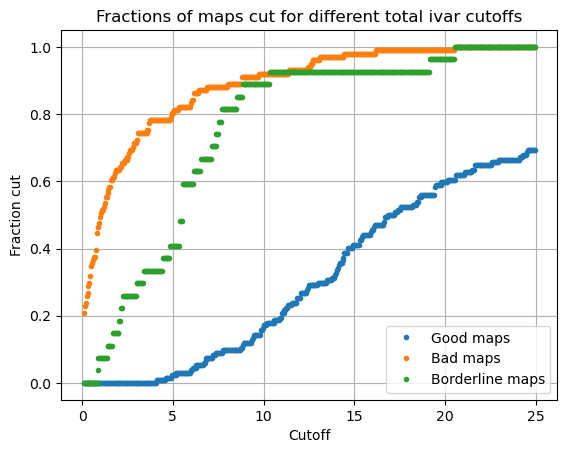

In [34]:
# Iterating over different ivar cutoffs to examine fraction that is cut
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
cutoffs = np.arange(0.1,25.0,0.05)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < cutoff)[0]
    #print(outlier_indices_ivar_sums)
    num_outlier = len(outlier_indices_ivar_sums)
    for i in range(num_outlier):
        if outlier_indices_ivar_sums[i] in all_good: in_good += 1
        elif outlier_indices_ivar_sums[i] in all_bad: in_bad += 1
        elif outlier_indices_ivar_sums[i] in borderline: in_border += 1
        elif outlier_indices_ivar_sums[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total ivar cutoffs")
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.grid()
plt.show()
plt.close()

528
360
Fraction of good maps cut at index with all bad cut:  0.3880597014925373
Fraction borderline cut at index with all bad cut:  1.0


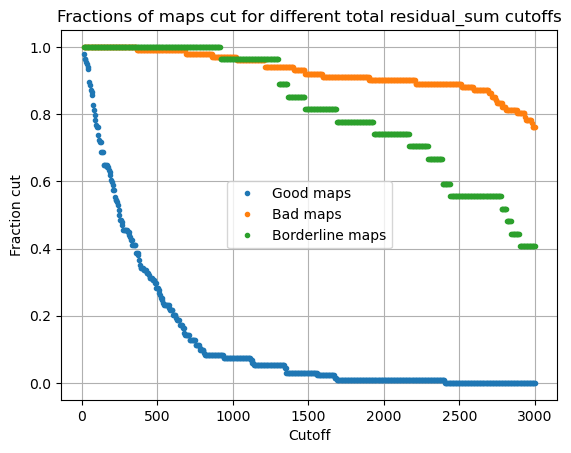

In [32]:
# Iterating over different cutoffs of residual_sums to examine fraction that is cut
# List of indices from looking at likelihoods by eye
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
cutoffs = np.arange(3000,10,-5) # Want to cut big values
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_residual_sums = np.where(residual_sums > cutoff)[0]
    #print(outlier_indices_residual_sums)
    num_outlier = len(outlier_indices_residual_sums)
    for i in range(num_outlier):
        if outlier_indices_residual_sums[i] in all_good: in_good += 1
        elif outlier_indices_residual_sums[i] in all_bad: in_bad += 1
        elif outlier_indices_residual_sums[i] in borderline: in_border += 1
        elif outlier_indices_ivar_sums[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total residual_sum cutoffs")
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.grid()
plt.show()
plt.close()

In [29]:
# needed to remove the two failed fits from all_bad or it screwed up this residual_sum calc
idx = np.where(residual_sums[all_bad] == 0.)[0]
print(all_bad[idx])

[ 95 246]


220
1900
Fraction of good maps cut at index with all bad cut:  0.007462686567164179
Fraction borderline cut at index with all bad cut:  0.8148148148148148


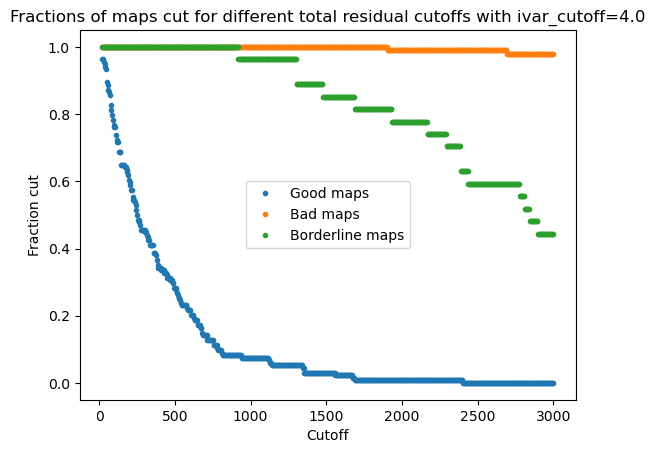

In [35]:
# Testing fixing the ivar cut and then sweeping out residual cut
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
ivar_cutoff = 4.0
cutoffs = np.arange(3000,15,-5)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < ivar_cutoff)[0]
    outlier_indices_residual_sums = np.where(residual_sums > cutoff)[0]
    #print(outlier_indices_ivar_sums)
    outlier_union = np.union1d(outlier_indices_residual_sums,outlier_indices_ivar_sums)
    num_outlier = len(outlier_union)
    for i in range(num_outlier):
        if outlier_union[i] in all_good: in_good += 1
        elif outlier_union[i] in all_bad: in_bad += 1
        elif outlier_union[i] in borderline: in_border += 1
        elif outlier_union[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total residual cutoffs with ivar_cutoff="+str(ivar_cutoff))
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()